# Machine Learning Analysis on Life Expectancy dataset after Outlier Handling

## Importing packages

In [13]:
# NumPy, pandas
import numpy as np
import pandas as pd
import csv

# Matplotlib and Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# SciKit-learn, XGBoost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

## Load Dataset

In [14]:
df = pd.read_csv('df_analysis.csv')

# Define X and y
X_ml = df.select_dtypes(include='number').drop(columns='Life_expectancy')
y_ml = df['Life_expectancy']

## Split and Scale data

In [15]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.2, random_state=42)

# Scale it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Models 

In [16]:
# Models to train
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0)
}

# Train & evaluate
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    results[name] = {
        'MAE': mean_absolute_error(y_test, preds),
        'MSE': root_mean_squared_error(y_test, preds),
        'RMSE': root_mean_squared_error(y_test, preds),
        'R2': r2_score(y_test, preds)
    }

# Create results DataFrame
results_df = pd.DataFrame(results).T.sort_values(by='R2', ascending=False)
print(results_df)

                       MAE       MSE      RMSE        R2
XGBoost           1.138150  1.844077  1.844077  0.942763
RandomForest      1.141260  1.890224  1.890224  0.939863
LinearRegression  2.194558  2.903635  2.903635  0.858094
Ridge             2.196396  2.905102  2.905102  0.857950
Lasso             2.684687  3.394047  3.394047  0.806111


### Cross-validation check

In [17]:
best_model = models['XGBoost']
scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"Mean R² (5-Fold CV): {scores.mean():.3f}")
print(f"All R² Scores: {scores}")

Mean R² (5-Fold CV): 0.932
All R² Scores: [0.90239553 0.94983786 0.92586888 0.95492592 0.92582012]


### Actual vs Predicted plot

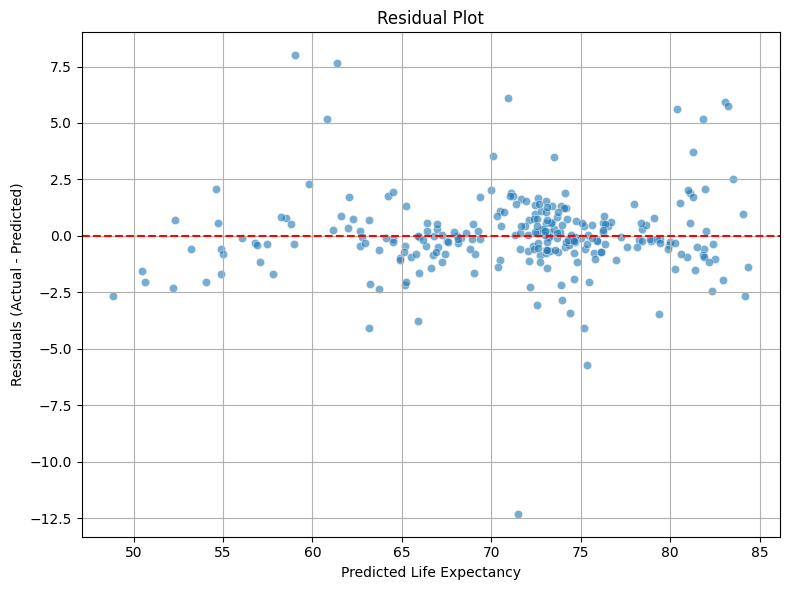

In [18]:
# Choosing the XGBoost as the best model 
best_preds = best_model.predict(X_test_scaled)

residuals = y_test - best_preds

plt.figure(figsize=(8, 6))
sns.scatterplot(x=best_preds, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Life Expectancy')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.tight_layout()
plt.savefig('plots/ML_Analysis/Residual_Plot.png')
plt.show()

Residuals mostly cluster around 0 (Red Line) indicating good predictions

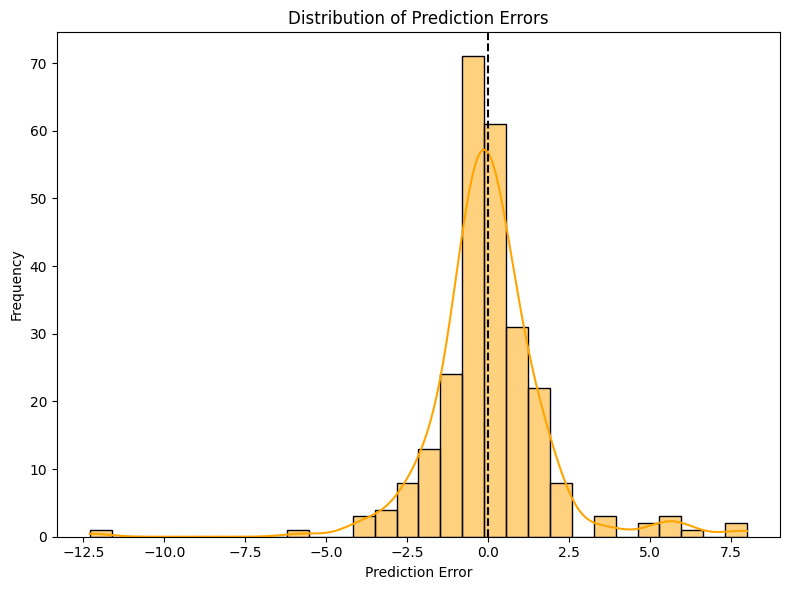

In [19]:
errors = y_test - best_preds

plt.figure(figsize=(8, 6))
sns.histplot(errors, bins=30, kde=True, color='orange')
plt.axvline(0, color='black', linestyle='--')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('plots/ML_Analysis/Prediction_Error_Distribution.png')
plt.show()

The model seems to have a good amount of accurate predictions

/var/folders/gq/b430spm17fnb2mgr7h_t65g80000gn/T/ipykernel_11877/1676629406.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_compare.groupby('Actual_Bin').mean()


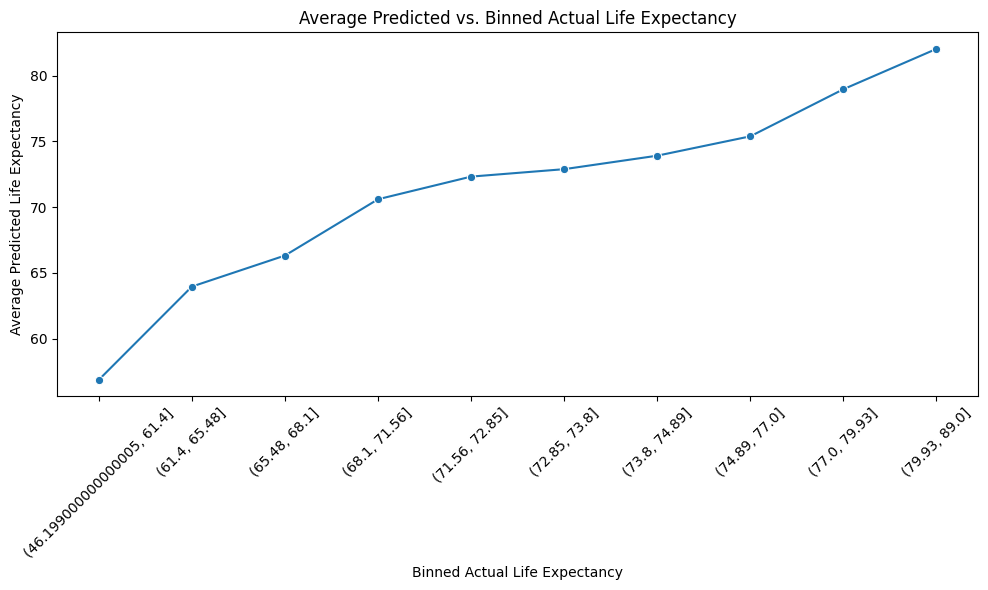

In [20]:
import pandas as pd

df_compare = pd.DataFrame({'Actual': y_test, 'Predicted': best_preds})
df_compare['Actual_Bin'] = pd.qcut(df_compare['Actual'], q=10)

grouped = df_compare.groupby('Actual_Bin').mean()

plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped, x=grouped.index.astype(str), y='Predicted', marker='o')
plt.xticks(rotation=45)
plt.title('Average Predicted vs. Binned Actual Life Expectancy')
plt.xlabel('Binned Actual Life Expectancy')
plt.ylabel('Average Predicted Life Expectancy')
plt.tight_layout()
plt.savefig('plots/ML_Analysis/Binned_Actual_and_Predicted.png')
plt.show()

The model seems to not overestimate as the average life expectancy falls within the bin range

### Feature Importances

/var/folders/gq/b430spm17fnb2mgr7h_t65g80000gn/T/ipykernel_11877/3820369225.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


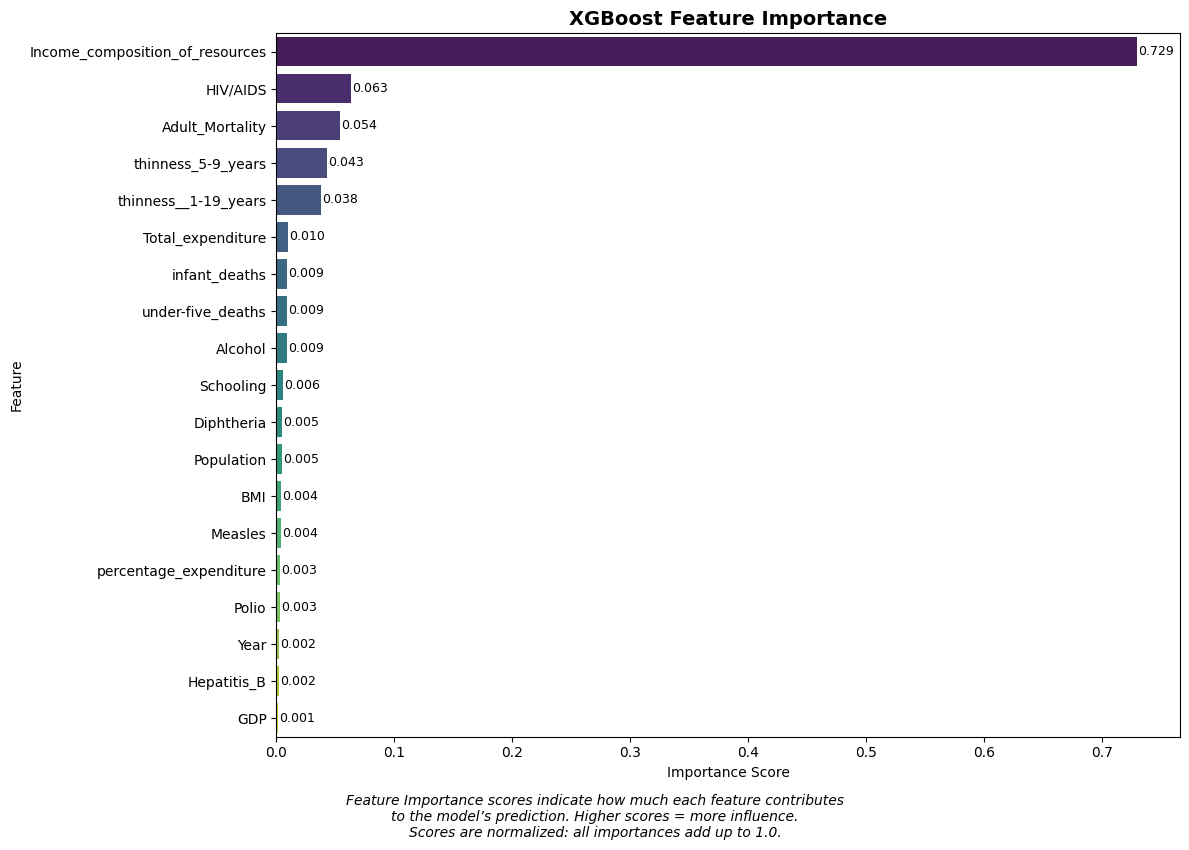

In [21]:
# Get feature importances and names
importances = best_model.feature_importances_
feature_names = X_train.columns

# Create and sort DataFrame
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# (Optional) Save to CSV
feat_imp_df.to_csv('plots/ML_Analysis/Feature_Importances.csv', index=False)

# Plot settings
plt.figure(figsize=(12, 8))
sns.barplot(
    data=feat_imp_df,
    x='Importance',
    y='Feature',
    palette='viridis'
)

# Annotate bars with values
for index, row in feat_imp_df.iterrows():
    plt.text(
        row['Importance'] + 0.001,
        index,
        f"{row['Importance']:.3f}",
        va='center',
        fontsize=9
    )

# Titles and labels
plt.title('XGBoost Feature Importance', fontsize=14, weight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Feature')

# Add key/explanation as a caption
caption = (
    "Feature Importance scores indicate how much each feature contributes\n"
    "to the model’s prediction. Higher scores = more influence.\n"
    "Scores are normalized: all importances add up to 1.0."
)
plt.figtext(0.5, -0.05, caption, wrap=True, ha='center', fontsize=10, style='italic')
plt.tight_layout()

# Save and show
plt.savefig('plots/Feature_Importance_Annotated.png')
plt.show()

## Hyperparameter tuning with RandomizedSearchCV

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import randint, uniform
import numpy as np

# Define the hyperparameter distributions (not a full grid)
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(5, 30, 5)),
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit on training data
random_search.fit(X_train_scaled, y_train)

# Get best estimator
best_rf_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Evaluate on test set
best_rf_preds = best_rf_model.predict(X_test_scaled)
print(f"R²: {r2_score(y_test, best_rf_preds):.3f}")
print(f"MAE: {mean_absolute_error(y_test, best_rf_preds):.3f}")
mse = mean_squared_error(y_test, best_rf_preds)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.3f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 484}
R²: 0.944
MAE: 1.167
RMSE: 1.825


The trained **RandomForestRegressor** model shows strong performance on the test set:

| **Metric** | **Value** | **Interpretation** |
|------------|-----------|--------------------|
| R²         | 0.944     | Explains 94.4% of the variance in life expectancy |
| MAE        | 1.167     | Average prediction error is ~1.17 years |
| RMSE       | 1.825     | Typical error is ~1.83 years; penalizes larger errors more than MAE |

This indicates the model is both **accurate and reliable** for predicting life expectancy based on the provided features.


## Saving the model

In [25]:
import joblib

# Save the model
joblib.dump(best_rf_model, 'Models/final_rf_model.pkl')

# Save rf_preds
np.save("Models/rf_preds.npy", best_rf_preds)

This model results can now be used to compare with a Deep learning model